# Climate Projection Module - Week 1 - Classwork

## In-class manipulation : Statistics on historical data
The aim of this first notebook is to accompany you in class in exploring measurements of temperature. We start by local measurements of air temperature near the surface (2 meters above ground, which is a standard measurement) and corresponds to a person's sensory experience of *atmospheric temperature*. The measurements allow you to explore a timeseries, its variations, the timescales of these variations, and the effect of averaging over days, seasons or years. A specific question to start can be events of noticeable heat, as *heat waves* will be our topic for homeworks 1 and 2. 

This notebook comprises **two parts and one appendix**: 
1- Local measurements of temperature for two decades - SIRTA data
2- Globally averaged surface temperatures since 1880
Appendix - global temperatures

**Part 1** (SIRTA data) is the longest and gives you the opportunity to explore a long timeseries of local temperature measurements, its variations and the effect of averaging. 

**Part 2** gives you the opportunity of exploring the *observed* variability and trends in globally averaged surface temperature. 

For simplicity, we focus in both parts on *timeseries*. The **appendix** offers the opportunity, for motivated students, to explore the *spatial* variations of surface temperature. 

## General philosophy
The aim of the notebook is to provide basic functions to allow you to read the data, manipulate and make simple plots rather easily. Some plots are made, as suggestions. The plots and manipulations carried out are intended as examples and starting points for your exploration of the data. Many features can be investigated, with events of heat in mind, but not only. There is not a *right answer* to obtain; asking questions and thinking about strategies to (partially) answer is closer to the purpose of this notebook. 

## Tools, packages 
In addition to common python packages (numpy, matplotlib), we use two packages that are likely less familiar: **pandas** makes it easier to manipulate data that are referenced by dates. We will use a specific pandas object, DataFrames, which has named columns and allows for dates to index rows. For plotting maps, the **cartopy** package is used. 
(Whereas it may be useful to explore possible manipulations of pandas DataFrames (eg for averaging), it is probably sufficient for maps to simply use the proposed code without investigating cartopy.)

# 1. Local measurements - SIRTA data

SIRTA (Site Instrumenté de Recherche par Télédétection Atmosphèrique) is an observatory installed on the campus of Ecole Polytechnique in 1998. It is operated by the Institut Pierre Simon Laplace (the institute for climate science in and around Paris, federating 9 laboratories). Among many other measurements, we here simply propose to analyze measurements of surface temperature because the quality of the measurements has been verified, providing a **timeseries of nearly two decades**. We will use the [Sirta ReOBS dataset](https://reobs.aeris-data.fr/en/download/), looking at the "ta" variable, representing the measured Air temperature at 2m above ground level in Celsius.

***Suggested questions***

- What are the start and end dates of the timeseries of temperature? What is the time resolution? 

- The temperature that we *feel* is known to vary from more than 30°C on hot summer afternoons, down to less than -5°C for exceptionnally cold winter periods. Now consider annually averaged temperatures: what do you expect the annual average temperature to be typically on Polytechnique's campus? How much do you expect it to vary from year to year? 

- What is the overall distribution of temperatures like? Does this distribution vary from year to year? What is the distribution of daily temperatures like? 

- On what timescales does the temperature vary? How can you extract known cycles? What remains? 

- Do you remember episodes of intense heat (in a region not too distant from Palaiseau)? Quantitatively, how does this translate in the measurements? How *anomalous* were temperatures for such or such episodes of noticeable heat? How *anomalous* can the temperatures get? Which characteristics or features matter (a very high maximum temperature? nights that do not cool? prolonged period of heat?) 

After importing the necessary packages below, we begin by reading and plotting the whole timeseries of SIRTA surface temperature, for the whole period of time. What are your first observations ? 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from datetime import timedelta
from datetime import datetime

### A first look at the timeseries 

Plot the timeseries and distribution of the temperature. Comment the form of the distribution.

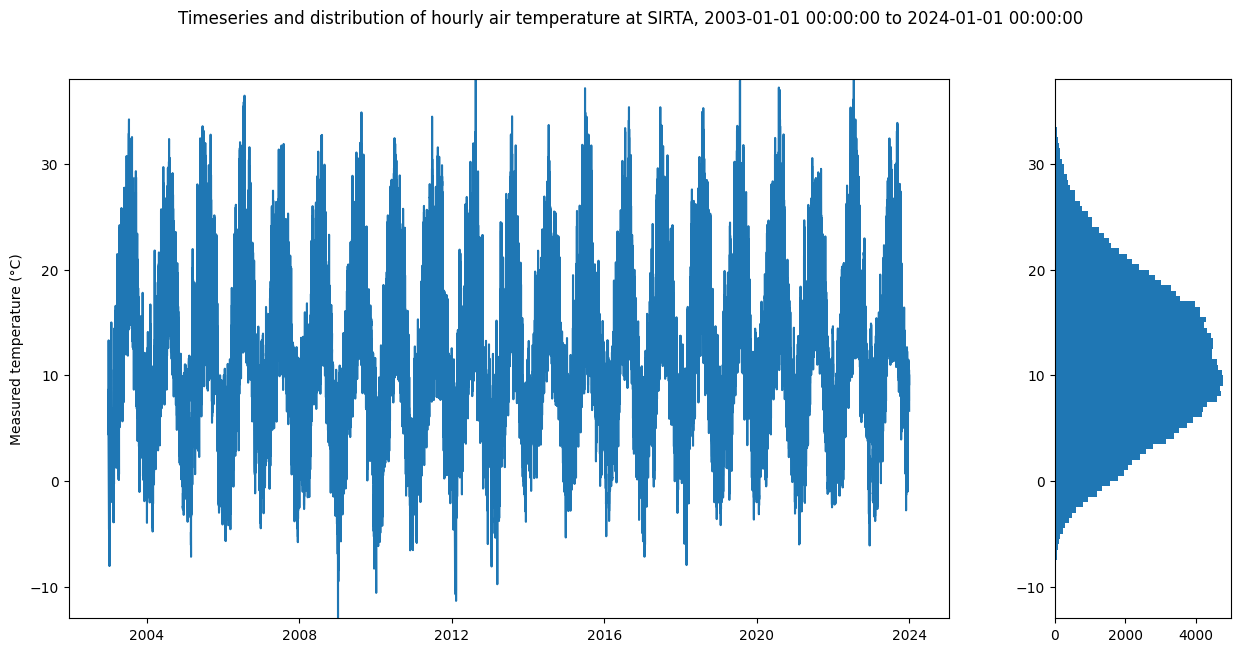

In [4]:
# Read the CSV file and store the data as a pandas DataFrame
file_path = 'data/ta_sirta.csv'
dfs = pd.read_csv(file_path, delimiter = ",", index_col=0)
dfs.index = pd.to_datetime(dfs.index)

# Set dates - MODIFY HERE TO VARY THE CYCLES
start_time = pd.to_datetime("2003-01-01") 
end_time = pd.to_datetime("2024-01-01")  

# Filtrage des valeurs de ta entre les deux dates spécifiées
filtered_dfs = dfs[(dfs.index >= start_time) & (dfs.index < end_time)]

# Extraction des valeurs de ta
ta_filtered = filtered_dfs['ta'].values

yminh = -13; ymaxh = 38     # parameters for plotting

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                       gridspec_kw={'width_ratios': [5, 1],'hspace': 0})
fig.suptitle(f'Timeseries and distribution of hourly air temperature at SIRTA, {start_time} to {end_time}')
ax1.plot(filtered_dfs.index, ta_filtered, label='Hourly SIRTA temperature observation')
ax1.set_ylim(yminh,ymaxh)
ax1.set_ylabel('Measured temperature (°C)')
tbins = np.arange(yminh,ymaxh,0.5) # set parameters for the histogram
ax2.hist(ta_filtered,orientation='horizontal', bins = tbins)
ax2.set_ylim(yminh,ymaxh)
plt.show()

### Functions to be compiled 

In [5]:
#Functions to be compiled before using the following cells

def cyclesandresiduals(temp,varh='ta'):
	""" 
    This function provides a first approximate estimate of the annual cycle 
    and of the diurnal cycle in temperature. 
    Two dataframes returned: temf (same length) 
	has additional columns ('ann', 'anndiu', and 'res')
	and diurnal cycle (24 values).
	The function has been written for temperature (varh='ta'), 
	but varh has been included as an optional argument so that 
	other variables could be investigated.
    ==  
    The nearly two decades available make it possible to obtain a smooth diurnal cycle by averaging over hour of the day.
    Averaging over two decades is not sufficient to obtain a smooth annual cycle (the reader is invited to try). 
    The common option is to smooth the obtained timeseries with a running window average. Here we propose (in part 
    as an illustration of a concept encountered in maths in previous years) to simply use the first component of the 
    Fourier series. The advantage is that this is quick and gives a very smooth annual cycle. What are the 
    disadvantages? 
    20240529 calculate the annual cycle with FFT, 
	calculate the dirunal cycle by averaging (enough samples)
	and return a dataframe which include the original timeseries
	the annual cycle, the sum of annual and diurnal cycle, 
	and the residuals (redundant)
	"""
	# DIURNAL CYCLE BASED ON ORIGINAL TIMESERIES
	temp.loc[:,('hour')] = temp.index.hour
	tdiurnal = temp.groupby('hour').mean()
	tmean = tdiurnal[varh].mean()
	# FOR THE ANNUAL CYCLE IDENTIFIED BY FFT, fill in nans
	# First need to fill nans, they are rather few and isolated, 
	#we use the ffill method available in pandas
	temf = temp.ffill()    # filling in nans
	ft   = np.fft.fft(temf[varh].values)
	ftmask = np.zeros(ft.shape)
	# Number of years in the record
	timeinterval = temf.index[-1] - temf.index[0]
	nyrs = int(np.round(timeinterval.days/365))
	ftmask[0] = 1;ftmask[nyrs-2:nyrs+3] = 1. ;ftmask[-nyrs-2:-nyrs+3] = 1. 
	temf['ann'] = np.real(np.fft.ifft(ft*ftmask)) 
	# PREPARE SUM OF ANNUAL AND DIURNAL CYCLE
	tcycle = np.zeros(temp[varh].values.shape)
	for nt,tdate in enumerate(temp.index):
	    tcycle[nt] = temf['ann'][tdate] + (tdiurnal[varh][tdate.hour] - tmean)
	temf['anndiu'] = tcycle 
	temf['res']    = temf[varh].values - temf['anndiu'].values 
	return temf, tdiurnal

def longtimeseries_pdf(temph,varh='ta',yminh=-13,ymaxh=38,colh="DarkOrange",dtemp=0.5, title = "Title"):
    """ This function plots the timeseries and the corresponding distribution on the side.  
    Plot is made with either the hourly resolution, or yearly averages, 
    possibility to specify the vertical axis and the color
    """ 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),
                       gridspec_kw={'width_ratios': [5, 1],'hspace': 0})
    fig.suptitle(title)
    ax1.plot(temph[varh],color=colh)
    ax1.set_ylim(yminh,ymaxh)
    tbins = np.arange(yminh,ymaxh,dtemp)
    ax2.hist(temph[varh].values,orientation='horizontal',bins=tbins,color=colh)
    ax2.set_ylim(yminh,ymaxh)
    plt.show()
    return None

def episode(temf,dt0,dt1):
	""" This function plots a specific interval of the tempeature timeseries (temf) 
    as a red curve, but also includes the annual cycle (gray curve) and the expected 
    hourly temperatures resulting from the addition of the annual and diurnal cycles. 
	"""
	tspec = temf[dt0:dt1]
	# from mailplot code, for reference
	#dtr = pd.date_range(start=mails.index[0],end=mails.index[-1],freq='1H')
	nighthours=[0, 1, 2, 3, 4, 5, 6, 7, 19, 20, 21, 22, 23]
	dtrnight = np.array([1*(dhh in nighthours) for dhh in tspec['hour']])
	plt.figure(figsize=(16,10))
	tspec['ta'].plot(linewidth=3,color='red')
	tspec['ann'].plot(linewidth=2,color='grey')
	tspec['anndiu'].plot(linewidth=2,color='k')
	plt.fill_between(tspec.index,-20*dtrnight,1000*dtrnight,color='k',alpha=0.1)
	# np.max(tspec['ta'],tspec['anndiu'])
	tanndiu = tspec['anndiu'].values
	tatas   = tspec['ta'].values
	tamin = np.min((tanndiu,tatas),0)
	tamax = np.max((tanndiu,tatas),0)	
	plt.fill_between(tspec.index,tamin,tanndiu,color='cornflowerblue',alpha=0.2)
	plt.fill_between(tspec.index,tanndiu,tamax,color='orangered',alpha=0.2)
	tmin = np.min((np.min(tspec.ta.values),np.min(tspec.anndiu.values)))
	tmax = np.max((np.max(tspec.ta.values),np.max(tspec.anndiu.values)))
	plt.axis([dt0,dt1,tmin-2,tmax+2])
	plt.title(f"Observations and average seasonal + daily variations during the period {dt0} to {dt1}")
	plt.legend()
	plt.ylabel('Surface temperature, degrees Celsius')
	#plt.savefig('ChapA01_temperature_timeseries_hourly_October2016.png')
	plt.show()
	return tspec



### A quick second look: annual averages

Let's take advantage of some of the tools provided by the pandas package to quickly obtain the same plot, but for annually averaged temperatures. 

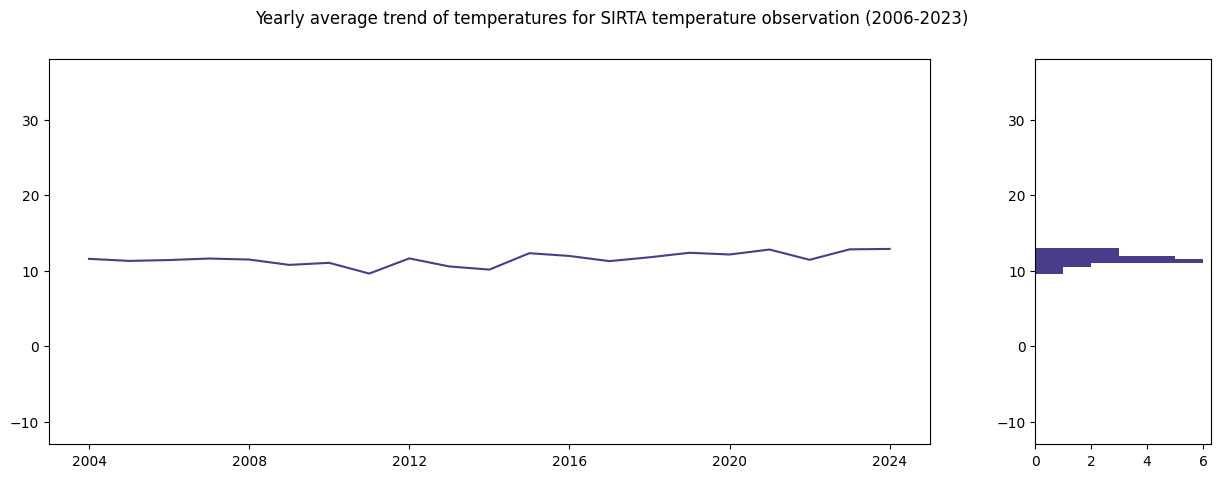

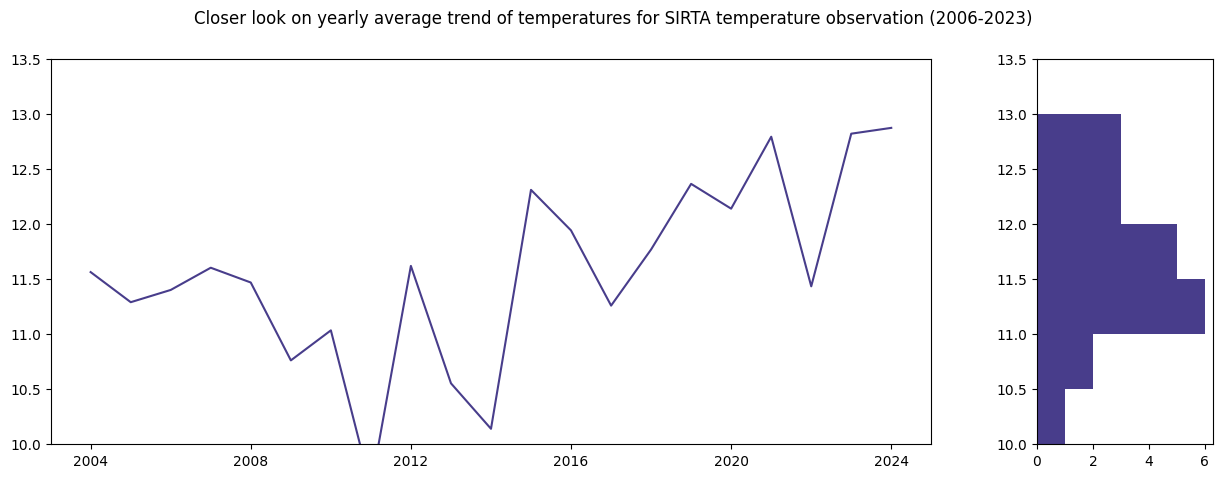

In [6]:
## PLOT YEARLY AVERAGE 
temp = filtered_dfs
# Average annually, to obtain a timeseries of 15 values, 15 annual means
tyr  = temp.resample('1YE').mean()
#tyr.describe()
longtimeseries_pdf(tyr,colh='darkslateblue', title = "Yearly average trend of temperatures for SIRTA temperature observation (2006-2023)")
longtimeseries_pdf(tyr,yminh=10.,ymaxh=13.5,colh='darkslateblue', title = "Closer look on yearly average trend of temperatures for SIRTA temperature observation (2006-2023)")


### How different are temperatures from one year to another? 

C:\Users\apoup\AppData\Local\Temp\ipykernel_21136\1297571027.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc[:,('hour')] = temp.index.hour
C:\Users\apoup\AppData\Local\Temp\ipykernel_21136\1713958715.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc[:,('yr')] = temp.index.year
C:\Users\apoup\AppData\Local\Temp\ipykernel_21136\1713958715.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

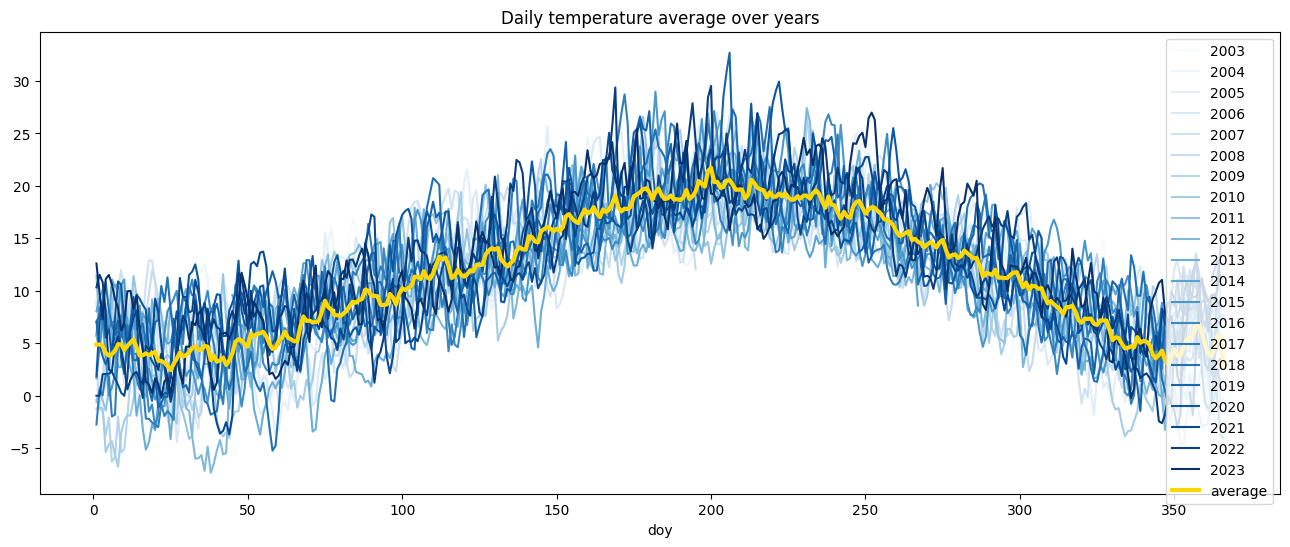

In [7]:
# Annual and diurnal cycles
temf, tdiurnal = cyclesandresiduals(temp)

temp.loc[:,('yr')] = temp.index.year
temp.loc[:,('doy')] = temp.index.dayofyear

# PLOT ALL YEARS EVOLUTION
tann = temp.groupby('doy').mean()['ta']
yrlycrves = []
colorlist = plt.colormaps['Blues'].resampled(21)(range(21))
plt.figure(figsize=(16,6))
for y in range(2003,2024):
    yrlycrves.append(temp[temp['yr']==y].groupby('doy').mean()['ta'])  
    yrlycrves[y-2003].plot(label = y, color = colorlist[y-2003])
tann.plot(linewidth='3',color='gold', label = "average")
plt.title("Daily temperature average over years")
plt.legend()
plt.show()


### Separating the annual and diurnal cycles

Let's take a look to the different components of the evolution of the measured temperature. Separate the global trend and the cycles (seasonal, daily, etc...). You can conceptualize them as different components of the Fourier transform.

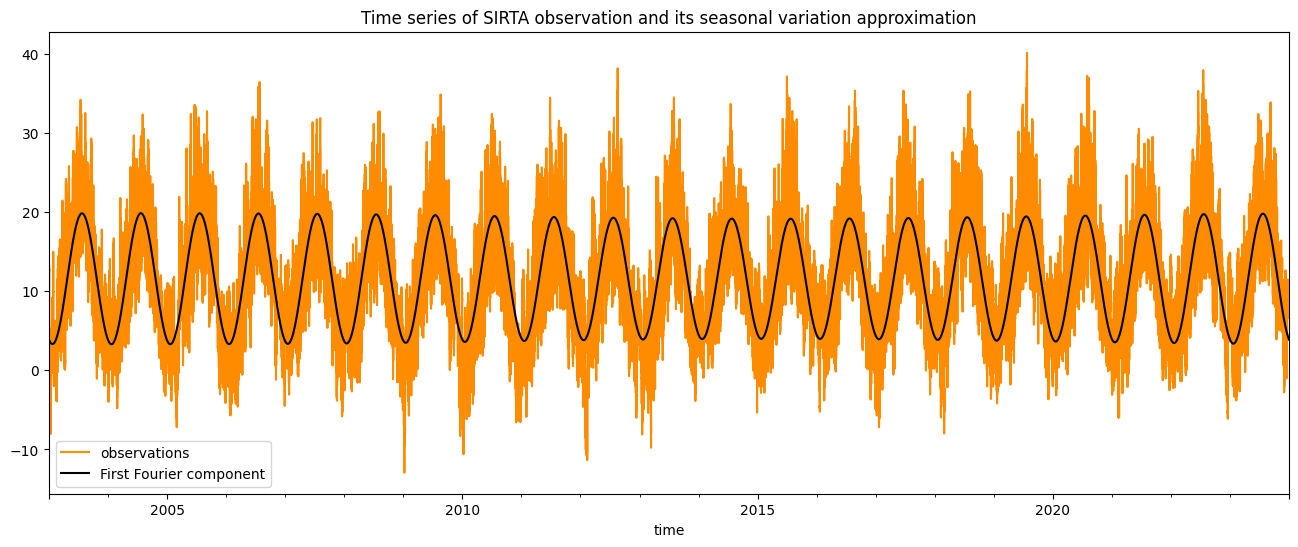

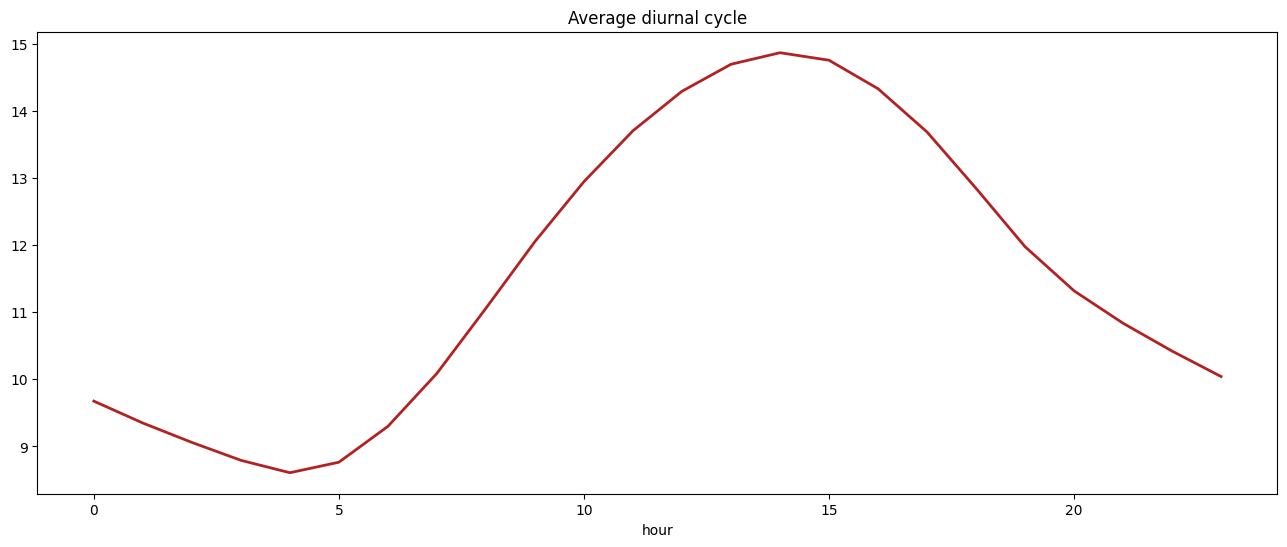

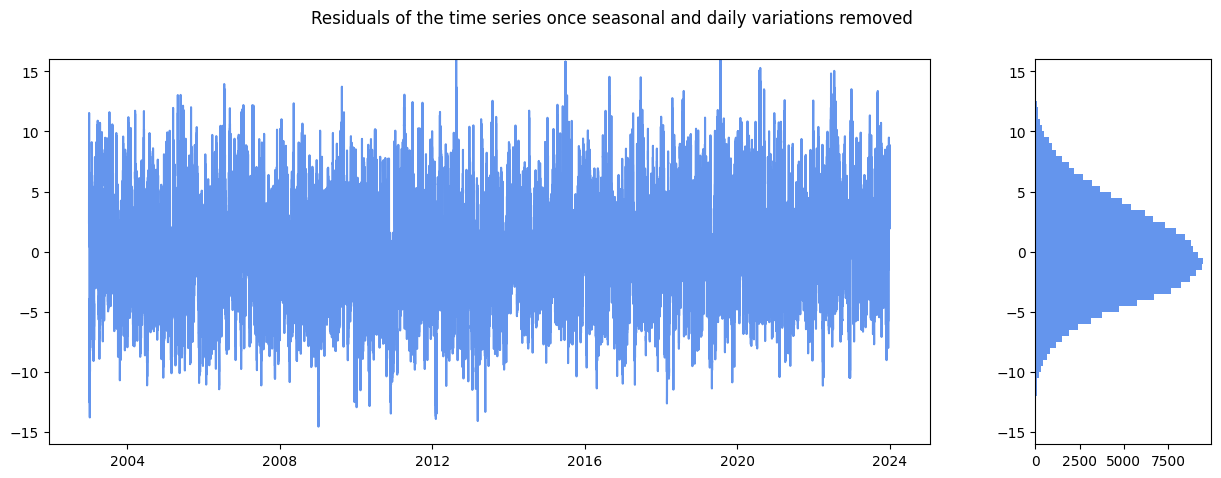

In [8]:
## PLOTTING ANNUAL CYCLE "ann" component is retrieved as the first Fourier component of the time serie, fitting pretty well the seasonal variations. Even though the exact variations don't exactly follow a sinusoidal evolution
plt.figure(figsize=(16,6))
temf['ta'].plot(color='DarkOrange', label = "observations")
temf['ann'].plot(color='k', label = "First Fourier component")
plt.legend(loc = "best")
plt.title("Time series of SIRTA observation and its seasonal variation approximation")
plt.show()

# PLOT AVERAGE DIURNAL CYCLE
plt.figure(figsize=(16,6))
temp.groupby('hour').mean()["ta"].plot(linewidth='2',color='firebrick')
plt.title("Average diurnal cycle")
plt.show()

## PLOT RESIDUALS : what is the residual variations if you remove the modelled seadonal variation
longtimeseries_pdf(temf,'res',-16,16,'cornflowerblue', title = "Residuals of the time series once seasonal and daily variations removed")

### Plotting specific episodes

The following allows you to explore specific events. A possibility may be to start from a memory of a warm event you have experienced (provided it was not geographically too distant from Palaiseau). The dates chosen below correspond to memories of particularly sunny days in the fall of 2006. 

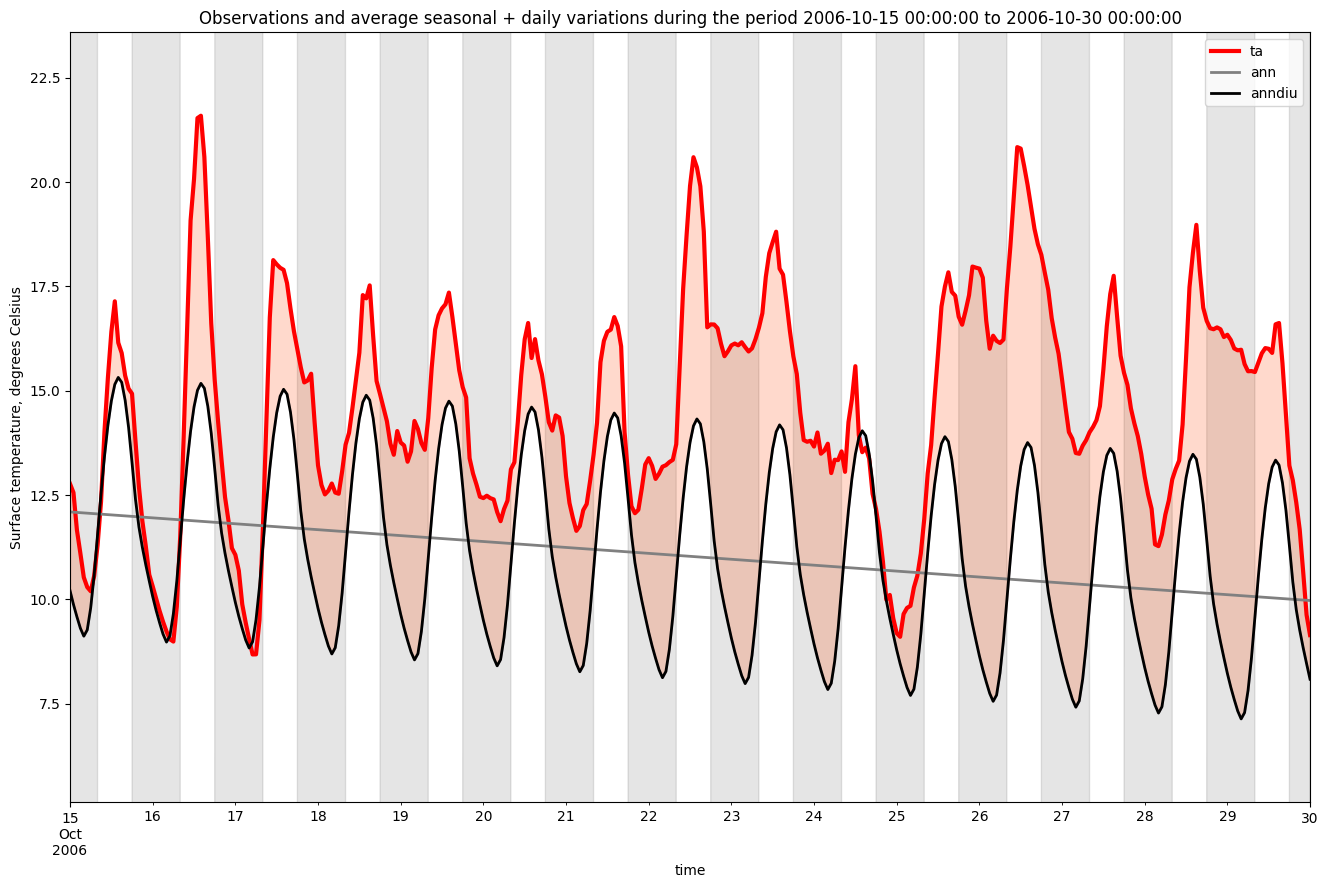

In [9]:
## PLOT A SPECIFIC TIME : YOU CAN CHOOSE A SPECIFIC DATE YOU WANT TO EXPLORE
dt0 = datetime(2006,10,15)
dt1 = datetime(2006,10,30)
tspec = episode(temf,dt0,dt1)

### Temperature distributions and trends

Timeseries over only two decades and for a single location is too limited to *seriously* investigate trends. Nonetheless, it is tempting and worthwhile to investigate. Observe the evolution of the yearly distribution over time. What does it suggest or confirm for trends? What can you say, if anything, about extreme values? 

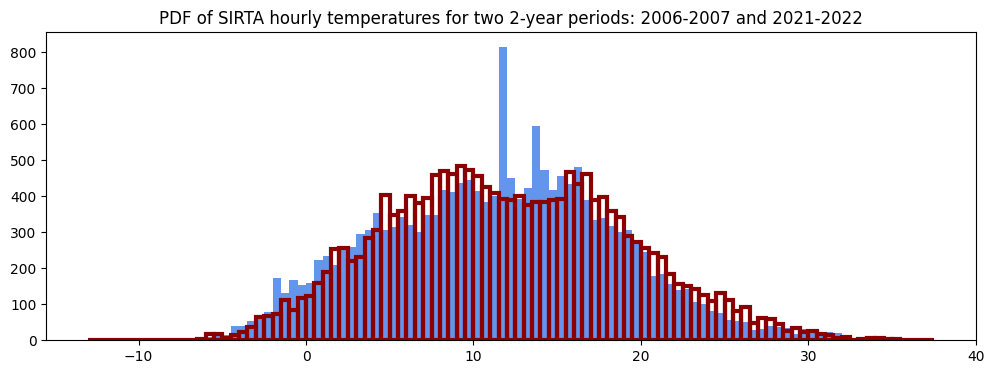

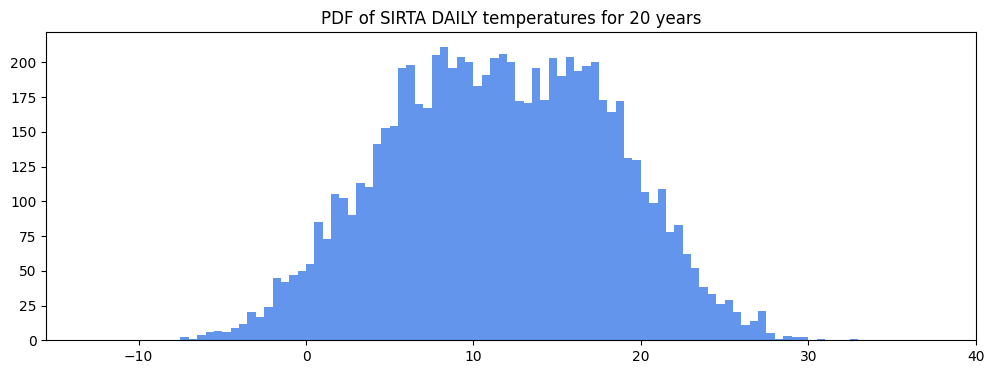

In [10]:
# Plotting parameters for the long timeseries
ymin = -13.; ymax = 38.
tbins = np.arange(ymin,ymax,0.5)
tday = temf.resample('1D').mean()


# PLOT PDFS : hourly temperatures
twoyears = timedelta(730,0)
fig, ax  = plt.subplots(nrows=1,ncols=1,figsize=(12,4))
dts1 = datetime(2006,1,1); dte1 = dts1 + twoyears
dte2 = datetime(2022,12,31); dts2 = dte2 - twoyears
ax.hist(temf['ta'][dts1:dte1].values,bins=tbins,facecolor='cornflowerblue')
ax.hist(temf['ta'][dts2:dte2].values,bins=tbins,facecolor='none',edgecolor='darkred',linewidth=3)
plt.title('PDF of SIRTA hourly temperatures for two 2-year periods: 2006-2007 and 2021-2022')
plt.show()

# PLOT PDFS : daily temperatures
twoyears = timedelta(730,0)
fig, ax  = plt.subplots(nrows=1,ncols=1,figsize=(12,4))
dts1 = datetime(2006,1,1); 
dte1 = datetime(2022,12,31); 
ax.hist(tday['ta'].values,bins=tbins,facecolor='cornflowerblue')
plt.title('PDF of SIRTA DAILY temperatures for 20 years')
plt.show()

# 2. global average temperature

What operation do we carry in order to access global average temperature ? We will there use the Global Surface Temperature anomalies from the [NASA website](https://data.giss.nasa.gov/gistemp/). More precisely, the dataset is the Global-mean monthly means, 1880-present, updated through most recent month. Reference is GISTEMP v4 and source GHCN-v4 1880-05/2024 + SST: ERSST v5 1880-05/2024 using elimination of outliers and homogeneity adjustment. It is quantified in temperature anomaly (°C) compared to the average temperature of the base period (1951-1980).

Precise method is described [here](https://pubs.giss.nasa.gov/abs/le05800h.html) as follows :

> We update this term using currently available spatial distributions of source data, state-of-the-art reanalyses, and incorporate independently derived estimates for ocean data processing, station homogenization, and other structural biases. The resulting 95% uncertainties are near 0.05°C in the global annual mean for the last 50 years and increase going back further in time reaching 0.15°C in 1880. In addition, we quantify the benefits and inherent uncertainty due to the GISTEMP interpolation and averaging method.

C:\Users\apoup\AppData\Local\Temp\ipykernel_21136\1526148526.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, end=end_date, freq='M')


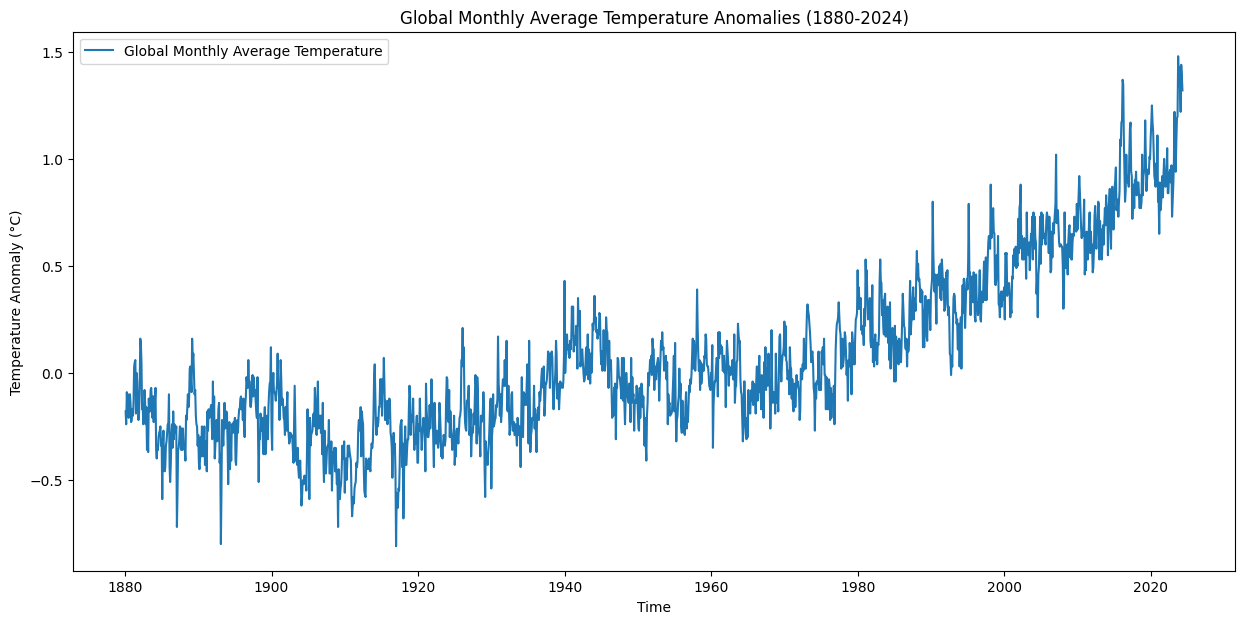

In [11]:
# Lire le fichier CSV
file_path = 'data/GLB.Ts+dSST.csv'
df = pd.read_csv(file_path, delimiter = ";", index_col=0)

# Convertir les données du DataFrame en une liste
SST = [float(x) for x in df.values.flatten().tolist()[:-8]]

# Définir la plage de dates
start_date = '1880-01'
end_date = '2024-05'

# Créer la liste de dates avec une fréquence mensuelle
dates = pd.date_range(start=start_date, end=end_date, freq='M')

# Afficher les données en fonction du temps
plt.figure(figsize=(15, 7))
plt.plot(dates, SST, label='Global Monthly Average Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Global Monthly Average Temperature Anomalies (1880-2024)')
plt.legend()
plt.show()

Comment the different components of the long term evolution of global average of surface temperature, separating between directional trend and natural variability.

Try to erase the seasonal variability, what do you get ?

C:\Users\apoup\AppData\Local\Temp\ipykernel_21136\3725688789.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(start=start_date, end=end_date, freq='Y')


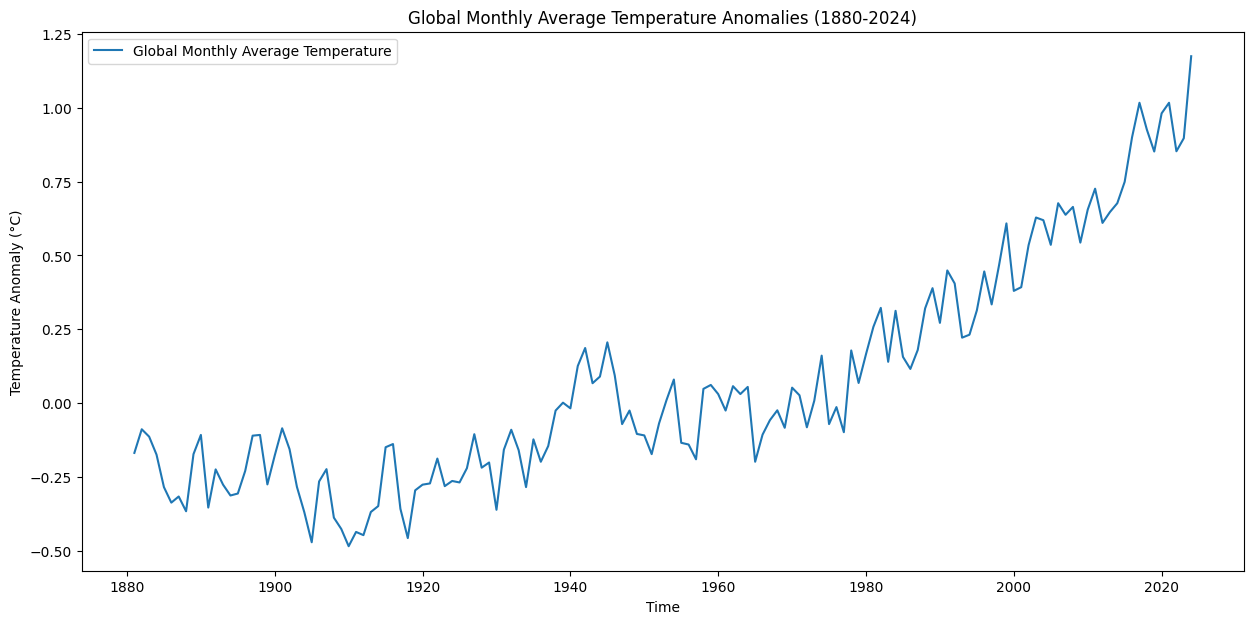

In [12]:
# Calcul des températures moyennes annuelles
# On commence par enlever la dernière année où les données sont incomplètes
df_c = df.iloc[:-1]
df_c = df_c.apply(pd.to_numeric, errors='coerce')
df_c['Annual'] = df_c.mean(axis=1)

# DataFrame contenant uniquement les températures moyennes annuelles
annual_avg_df = df_c[['Annual']]

# Convertir les données du DataFrame en une liste
SST_avg = annual_avg_df.values.flatten().tolist()

# Définir la plage de dates
start_date = '1880'
end_date = '2024'

# Créer la liste de dates avec une fréquence mensuelle
dates = pd.date_range(start=start_date, end=end_date, freq='Y')

# Afficher les données en fonction du temps
plt.figure(figsize=(15, 7))
plt.plot(dates, SST_avg, label='Global Monthly Average Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Global Monthly Average Temperature Anomalies (1880-2024)')
plt.legend()
plt.show()

## APPENDIX - supplementary material : Spatial dataset manipulation

On this global dataset, you can see the effects of the natural variability of the climate. Can you identify the effect of the last El Nino cycles, or the last big volcano eruptions ? (El Chichon 1982 or Pinatubo 1991)

Let us now explore the main characteristics of the spatial distribution of temperature observation (and reanalysis data).

In [13]:
import netCDF4 as nc4

In [14]:
ds = nc4.Dataset('data/tas_day_IPSL-CM5A-LR_historical_r1i1p1_EWEMBI_20010101-20011231.nc4' , mode='r')

def read_nc4_file(dataset):
    try:
        # Afficher les dimensions du fichier
        print("Dimensions:")
        for dim_name, dim in dataset.dimensions.items():
            print(f"  {dim_name}: {len(dim)}")
        
        # Afficher les variables du fichier
        print("\nVariables:")
        for var_name, var in dataset.variables.items():
            print(f"  {var_name}: {var.dimensions} - {var.shape}")
        
        # Exemple de lecture de données spécifiques (modifiez selon vos besoins)
        if 'temperature' in dataset.variables:
            temperature_data = dataset.variables['temperature'][:]
            print("\nTemperature data:")
            print(temperature_data)

    
    except Exception as e:
        print(f"An error occurred: {e}")


read_nc4_file(ds)


Dimensions:
  lon: 720
  lat: 360
  time: 365

Variables:
  lon: ('lon',) - (720,)
  lat: ('lat',) - (360,)
  time: ('time',) - (365,)
  tas: ('time', 'lat', 'lon') - (365, 360, 720)


Let us display the world temperature reanalysis for 2 specific dates at 2 different seasons. What do you see ?

**Precise the temperature scale.**
**regarder pour rajouter les côtes**

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import cartopy.crs as ccrs 

def mapdate(dataset, doy,cmaph='coolwarm'):
    """ 20240528 Make a map of temperature at one "time", given by t1: 
	doy is the order of the day in the year 2001
	We plot the array (360,720) of values for that date
	"""
    f = dataset
    t = f.variables['time'][:]
    tas = dataset.variables['tas'][:]
    tas_extract = tas[doy, :, :]  # date choisie
    #ax = plt.axes(projection=ccrs.PlateCarree())
    fig = plt.figure(figsize = (12,6))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    #ax = plt.axes(projection=ccrs.Mollweide(central_longitude=155.)) 
    lats = f.variables['lat'][:]
    lons = f.variables['lon'][:]
    plt.contourf(lons, lats, tas_extract, 21,transform=ccrs.PlateCarree(),cmap=cmaph, vmin = 210, vmax = 315) # need to set vmin and vmax to have comparable scale between graphs
    plt.colorbar(label='Temperature (K)', pad = 0.2)
    ax.coastlines()         
    plt.title(f"World temperature for the date of year {doy} of the year 2001")
    plt.show()                                        

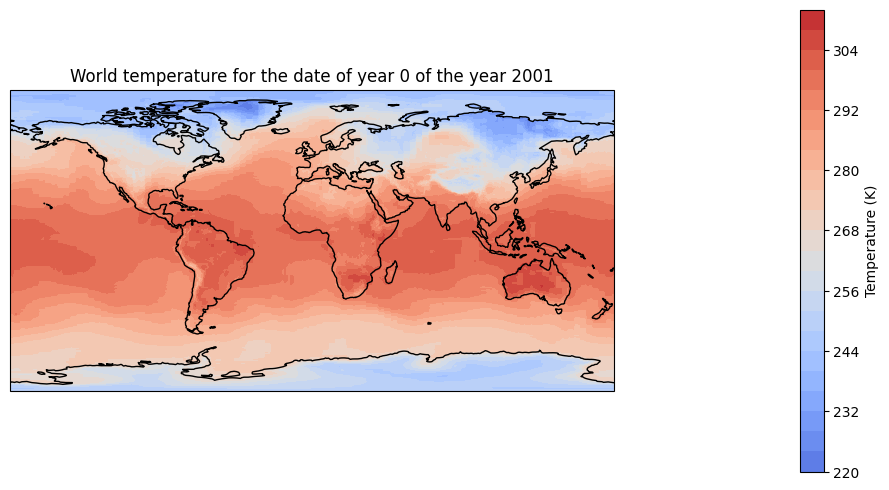

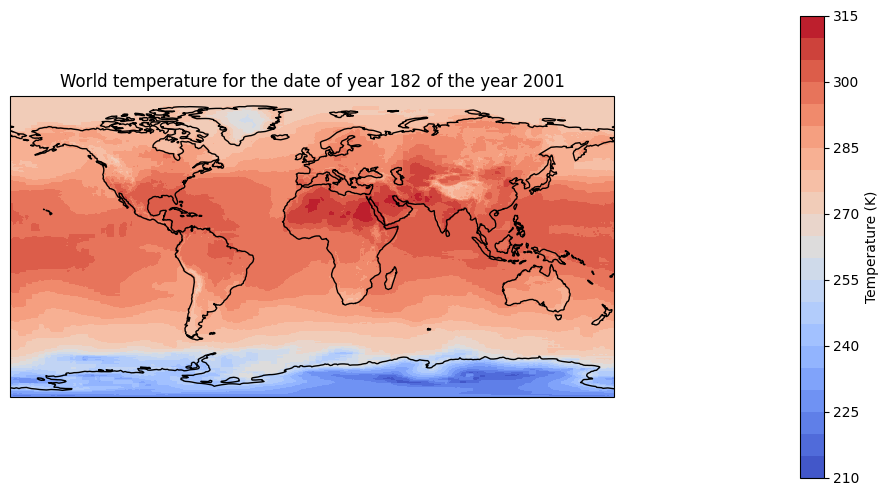

In [16]:
mapdate(ds, 0, cmaph = "coolwarm")
mapdate(ds, 182,  cmaph = "coolwarm")

Explorons quelques caractéristiques clé de la répartition spatiale des températures pour cette année 2001.

- Traçons la moyenne zonale des températures
- L'évolution temporelle de la température moyenne de l'hémisphère Nord VS hémisphère Sud.

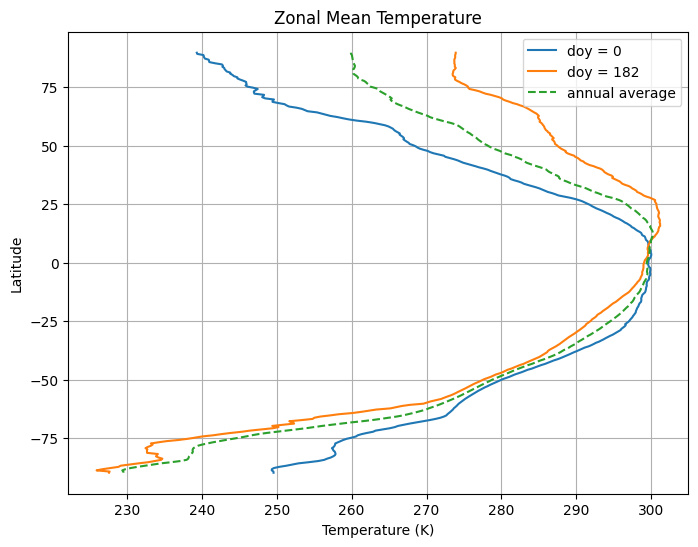

In [17]:
def plot_zonal_mean_temperature(dataset, doy):
    try:
        # Lire les variables nécessaires
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        tas = dataset.variables['tas'][doy, :, :]
        
        # Calculer la moyenne zonale (moyenne sur les longitudes)
        zonal_mean_tas = np.mean(tas, axis=1)
        
        # Créer la courbe
        
        plt.plot(zonal_mean_tas, lat, label = f"doy = {doy}")
    except Exception as e:
        print(f"An error occurred: {e}")

def plot_zonal_mean_temperature_annual(dataset):
    try:
        # Lire les variables nécessaires
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        tas = dataset.variables['tas'][:]
        
        # Calculer la moyenne annuelle des températures (moyenne sur la dimension "time")
        annual_mean_tas = np.mean(tas, axis=0)
        
        # Calculer la moyenne zonale (moyenne sur les longitudes)
        zonal_mean_tas = np.mean(annual_mean_tas, axis=1)
        
        # Créer la courbe
        plt.plot(zonal_mean_tas, lat,"--", label = f"annual average")
    except Exception as e:
        print(f"An error occurred: {e}")


plt.figure(figsize=(8, 6))
plt.xlabel('Temperature (K)')
plt.ylabel('Latitude')
plt.title(f'Zonal Mean Temperature')
plt.grid(True)
plot_zonal_mean_temperature(ds, 0)
plot_zonal_mean_temperature(ds, 182)
plot_zonal_mean_temperature_annual(ds)
plt.legend()
plt.show()

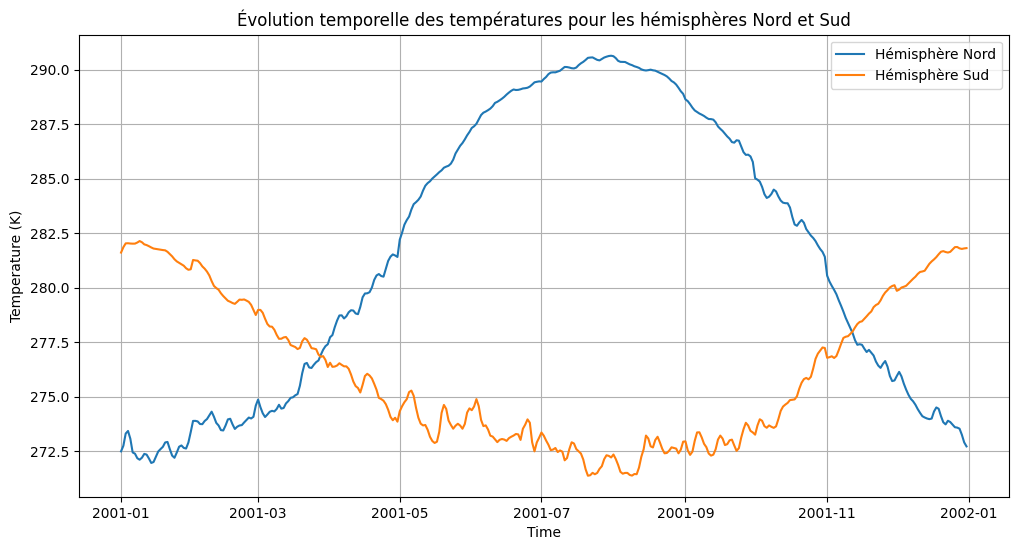

In [18]:

def plot_temporal_evolution_by_hemisphere(dataset):
    try:
        # Lire les variables nécessaires
        time = dataset.variables['time']
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        tas = dataset.variables['tas'][:]
        
        # Séparer les indices des latitudes pour les deux hémisphères
        north_indices = np.where(lat > 0)[0]
        south_indices = np.where(lat < 0)[0]
        
        # Calculer les moyennes temporelles pour chaque hémisphère
        tas_north = np.mean(tas[:, north_indices, :], axis=(1, 2))
        tas_south = np.mean(tas[:, south_indices, :], axis=(1, 2))

        # Convertir la variable time en dates compréhensibles
        times = nc4.num2date(time[:], units=time.units)
        
        # Convertir cftime.DatetimeGregorian en datetime.datetime, lisible par matplotlib
        times_datetime = [datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in times]

        # Créer les courbes
        plt.figure(figsize=(12, 6))
        plt.plot(times_datetime, tas_north, label='Hémisphère Nord')
        plt.plot(times_datetime, tas_south, label='Hémisphère Sud')
        plt.xlabel('Time')
        plt.ylabel('Temperature (K)')
        plt.title('Évolution temporelle des températures pour les hémisphères Nord et Sud')
        plt.legend()
        plt.grid(True)
        
        # Afficher les courbes
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")


plot_temporal_evolution_by_hemisphere(ds)
